<a href="https://colab.research.google.com/github/mcnica89/MATH4060/blob/main/Week_4_Calculate_PIG_strategies_with_value_iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [8]:
def PIG_matrix(R_max):
  #Matrix of movement transition probabilities matrix
  #for the runner locations in PIG on a reroll
  # -Assumes there is no bust (i.e. assuming you advance!)
  # -Capped at R_max (so you can't exceed runners past R_max) for the pruposes of simulation
  P = np.zeros((R_max+1,R_max+1))
  i,j = np.indices(P.shape)
  one_fifth = 1.0/5.0

  P[i+2==j] = one_fifth 
  P[i+3==j] = one_fifth
  P[i+4==j] = one_fifth
  P[i+5==j] = one_fifth
  P[i+6==j] = one_fifth

  #Another way to to do this is
  # for k in [2,3,4,5,6]:
  #   P[i+k==j] = one_fifth


  #Make the last column larger so that each row sums to 1
  #This is effectively "rounding down" anything that goes over S_max 
  row_sums = np.sum(P,axis=1)
  P[:,R_max] += 1-row_sums

  return(P)
  

In [9]:
np.set_printoptions(precision=3,suppress=True)
PIG_matrix(8)

array([[0. , 0. , 0.2, 0.2, 0.2, 0.2, 0.2, 0. , 0. ],
       [0. , 0. , 0. , 0.2, 0.2, 0.2, 0.2, 0.2, 0. ],
       [0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 0.4],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.2, 0.6],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.8],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]])

# Solo PIG version 1: Distance maximization

$\mathcal{S} = \{r\}$ 
where

$r \in \{0,1,2,\ldots\} = \text{location of the runner}$


---


$\mathcal{A} = \{\text{Roll again},\text{Stay}\}$ 


---


$R_t = \begin{cases} s\text{ if Stay} \\ 0\text{ if roll again} \end{cases}$ 

Notation: We use the 
```
q_stay[x] 
```
to mean: $q_\ast(x,\text{Stay})$

and
```
q_roll_again[x] 
```
to mean: $q_\ast(x,\text{Roll Again})$




In [10]:
def init_value_funcs_distance(R_max):

  #Value of staying. This is exactly correct!
  #q_stay[x] = x
  q_stay = np.arange(R_max+1) 

  #Value of rolling again. We have to determine this
  #q_roll_again[x] = ?
  #We intialize it to all zeros since the value is at least 0
  # and we'll work our way up to the true value
  q_roll_again = np.zeros(R_max+1)

  #Optimal value function is the maximum of staying or rolling again 
  v_star = np.maximum(q_stay,q_roll_again)

  return q_stay, q_roll_again, v_star


In [21]:
def value_iteration_distance(R_max, num_iters=1):
  '''Does one round of value iteration for PIG'''
  q_stay, q_roll_again, v_star = init_value_funcs_distance(R_max)
  P = PIG_matrix(R_max)

  for i in range(num_iters):

    #Version 1: with a FOR LOOP
    #PROS:  Only need one iteration (for this particular problem!)
    #CONS:  Slower!
    for r in np.arange(R_max,-1,-1): #Count down from R_max to 0
      q_roll_again[r] = 1/6*0 + 5/6*np.einsum('i,i',v_star,P[r,:])
      v_star = np.maximum(q_stay,q_roll_again)
    
    #Version 2: with a MATRIX MULTIPLICATION
    #PROS: Matrix multiplication is very fast on computers!
    #CONS: Need more than one iteration!
    #q_roll_again = 1/6*0 + 5/6*np.einsum('i,si',v_star,P)
    #v_star = np.maximum(q_stay,q_roll_again)
    print(q_roll_again)

      

  return v_star, q_roll_again > q_stay


In [22]:
v_star, roll_again = value_iteration_distance(10,5)

[6.011 6.283 6.534 6.829 7.231 7.583 7.889 8.167 8.333 8.333 8.333]
[6.011 6.283 6.534 6.829 7.231 7.583 7.889 8.167 8.333 8.333 8.333]
[6.011 6.283 6.534 6.829 7.231 7.583 7.889 8.167 8.333 8.333 8.333]
[6.011 6.283 6.534 6.829 7.231 7.583 7.889 8.167 8.333 8.333 8.333]
[6.011 6.283 6.534 6.829 7.231 7.583 7.889 8.167 8.333 8.333 8.333]


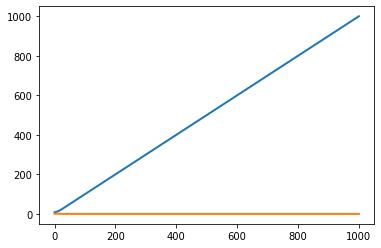

In [20]:
v_star, roll_again = value_iteration_distance(1000,100)
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(v_star,linewidth=2) 
ax.plot(roll_again, linewidth=2)

# Solo PIG version 2: Target maximization

What is the strategy that maximizes reaching a certain target in a certain number of turns?

$\mathcal{S} = \{r,s,t\} $
where :

$ r = \text{ Runner location } \in \{0,1,2\ldots\}$

$ s = \text{ Spaces remaining } \in \{0,1,2\ldots\}$

$ t = \text{ Turns remaining after this turn } \in \{1,2,\ldots\}$


---


$\mathcal{A} = \{\text{Roll again}, \text{Stay} \}$


---


$R_t = \begin{cases} 1\text{ if Target achieved!} \\ 0\text{ otherwise} \end{cases}$ 



In [26]:
def visualizeMatrix(M): #visualize a matrix as a plot including the scale
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(M, interpolation='nearest')
  fig.colorbar(cax)

  plt.show()
  return

In [23]:
def init_value_funcs_target(R_max,S_max,T_max):

  #Value of staying. This is exactly correct!
  q_stay = np.zeros((R_max+1,S_max+1,T_max+1))
  r,s,t = np.indices(q_stay.shape)
  q_stay[ r>=s ] = 1 #If your runner is larger than the target you win by staying!
  #otherwise the matrix will have all zeros to start and we will fill in with value iteration


  #Value of rolling again. We have to determine this
  #q_roll_again[x] = ?
  #We intialize it to all zeros since the value is at least 0
  # and we'll work our way up to the true value
  q_roll_again = np.zeros((R_max+1,S_max+1,T_max+1))

  #Optimal value function is the maximum of staying or rolling again 
  v_star = np.maximum(q_stay,q_roll_again)

  return q_stay, q_roll_again, v_star

In [24]:
q_stay, q_roll_again, v_star = init_value_funcs_target(100,100,3)

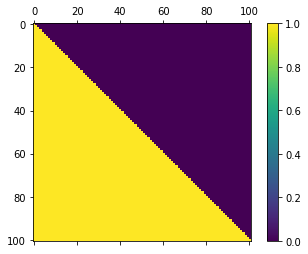

In [46]:
visualizeMatrix(q_stay[:,:,0])

In [45]:
def PIG_value_iteration_target(R_max,S_max,T_max, num_iters=1):
  '''Does value iteration for PIG using the target objecting'''
  q_stay, q_roll_again, v_star = init_value_funcs_target(R_max,S_max,T_max)
  P = PIG_matrix(R_max)

  for i in range(num_iters):
    for t in np.arange(0,T_max+1):
      for s in np.arange(0,S_max+1):
        for r in np.arange(R_max,-1,-1):
          if t >= 1:
            bust_value = v_star[0,s,t-1] #If you bust you go down to zero runners and one less turn
          elif t == 0:
            bust_value = 0 #If no turns left you just lose when you bust!

          prob_bust = 1.0/6.0

          #Update acording to the Bellman Eqn!
          q_roll_again[r,s,t] = prob_bust*bust_value + (1-prob_bust)*np.einsum('i,i',v_star[:,s,t],P[r,:]) 
           
          #If there is time left, then choosing to stay will advance your position by r and reduce time left by 1 
          if t>= 1 and s>r:
            q_stay[r,s,t] = v_star[0,s-r,t-1]
            
          #v_star is the maximum over all possible actions               
          v_star[r,s,t] = np.maximum(q_stay[r,s,t],q_roll_again[r,s,t])
    
  return v_star, q_roll_again > q_stay

In [43]:
v_star, roll_again = PIG_value_iteration_target(200,200,10)

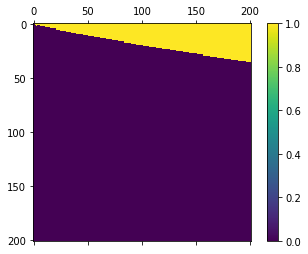

In [49]:
visualizeMatrix(roll_again[:,:,10])